Importing Required Packages

In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

from imblearn.combine import SMOTEENN

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score






Loading Dataset


In [21]:
df = pd.read_csv("/Customer Conversion Prediction - Customer Conversion Prediction.csv")
df.head()

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y
0,58,management,married,tertiary,unknown,5,may,261,1,unknown,no
1,44,technician,single,secondary,unknown,5,may,151,1,unknown,no
2,33,entrepreneur,married,secondary,unknown,5,may,76,1,unknown,no
3,47,blue-collar,married,unknown,unknown,5,may,92,1,unknown,no
4,33,unknown,single,unknown,unknown,5,may,198,1,unknown,no


In [22]:
df.shape

(45211, 11)

Checking Missing Values

In [23]:
df.isnull().sum()


age               0
job               0
marital           0
education_qual    0
call_type         0
day               0
mon               0
dur               0
num_calls         0
prev_outcome      0
y                 0
dtype: int64

Dropping Duplicates

In [24]:
df.duplicated().sum()
df = df.drop_duplicates()

Checking Datatypes

In [25]:
df.dtypes


age                int64
job               object
marital           object
education_qual    object
call_type         object
day                int64
mon               object
dur                int64
num_calls          int64
prev_outcome      object
y                 object
dtype: object

Describing Numarical Columns

In [26]:
df.describe()

,age,day,dur,num_calls
count,45205.000000,45205.00000,45205.000000,45205.000000
mean,40.937087,15.80688,258.183055,2.763898
std,10.619130,8.32234,257.538504,3.098189
min,18.000000,1.00000,0.000000,1.000000
25%,33.000000,8.00000,103.000000,1.000000
50%,39.000000,16.00000,180.000000,2.000000
75%,48.000000,21.00000,319.000000,3.000000
max,95.000000,31.00000,4918.000000,63.000000


Checking Outliers

<AxesSubplot:xlabel='age'>

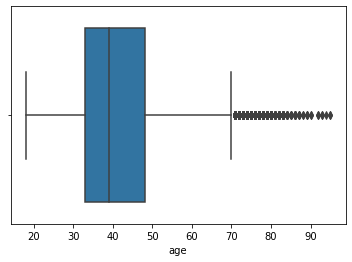

In [27]:

sns.boxplot(df['age'])

Function to find Outliers

In [29]:
def detect_outliers(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5*(IQR)
    upper_fence = Q3 + 1.5*(IQR)
    total_outliers = dataframe.loc[(dataframe[column] < lower_fence) | (dataframe[column] > upper_fence)]
    if len(total_outliers):
      print("LowerFence: {}, UpperFence: {}\n{} Outliers present in {}".format(lower_fence, upper_fence, len(total_outliers), column))

In [30]:
def clip_outliers(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5*(IQR)
    upper_fence = Q3 + 1.5*(IQR)
    dataframe[column] = dataframe[column].clip(lower_fence, upper_fence)

In [31]:
detect_outliers(df, "age")

LowerFence: 10.5, UpperFence: 70.5
487 Outliers present in age


Clip the outliers between upper and Lower fence values

In [32]:

clip_outliers(df, "age")

After Cleaning Outliers

<AxesSubplot:xlabel='age'>

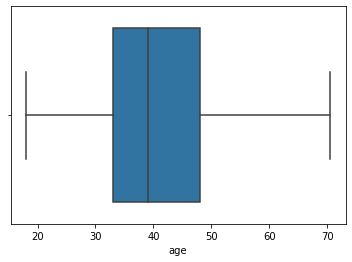

In [33]:

sns.boxplot(df['age'])

Checking Outliers

<AxesSubplot:xlabel='dur'>

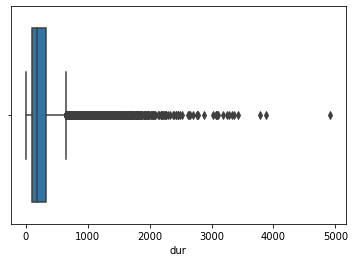

In [34]:
sns.boxplot(df['dur'])

In [35]:
detect_outliers(df, 'dur')

LowerFence: -221.0, UpperFence: 643.0
3235 Outliers present in dur


In [36]:

clip_outliers(df, "dur")

<AxesSubplot:xlabel='dur'>

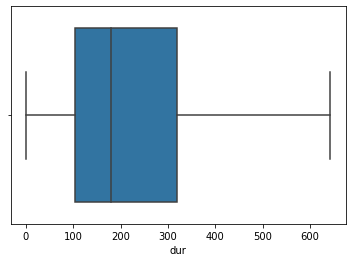

In [37]:

sns.boxplot(df["dur"])

In [38]:
df.dur.describe()

count    45205.00000
mean       234.95620
std        176.75476
min          0.00000
25%        103.00000
50%        180.00000
75%        319.00000
max        643.00000
Name: dur, dtype: float64

Checking Outliers

<AxesSubplot:xlabel='num_calls'>

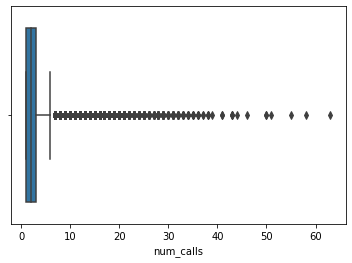

In [39]:
sns.boxplot(df['num_calls'])

In [40]:
detect_outliers(df, "num_calls")

LowerFence: -2.0, UpperFence: 6.0
3064 Outliers present in num_calls


In [41]:
clip_outliers(df, "num_calls")

After Cleaning Outliers

<AxesSubplot:xlabel='num_calls'>

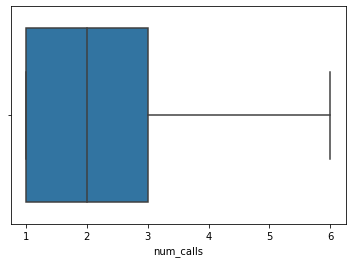

In [42]:
sns.boxplot(df['num_calls'])

In [43]:
df.day.describe()

count    45205.00000
mean        15.80688
std          8.32234
min          1.00000
25%          8.00000
50%         16.00000
75%         21.00000
max         31.00000
Name: day, dtype: float64

Cleaning Categorical Columns

In [44]:
for feature in df.select_dtypes(include="object").columns:
  if df[feature].nunique() < 25:
    print("\033[1m{:<15}\033[0m has {} unique values: {}".format(feature, df[feature].nunique(), list(df[feature].unique())))

job             has 12 unique values: ['management', 'technician', 'entrepreneur', 'blue-collar', 'unknown', 'retired', 'admin.', 'services', 'self-employed', 'unemployed', 'housemaid', 'student']
marital         has 3 unique values: ['married', 'single', 'divorced']
education_qual  has 4 unique values: ['tertiary', 'secondary', 'unknown', 'primary']
call_type       has 3 unique values: ['unknown', 'cellular', 'telephone']
mon             has 12 unique values: ['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'sep']
prev_outcome    has 4 unique values: ['unknown', 'failure', 'other', 'success']
y               has 2 unique values: ['no', 'yes']


In [45]:

df['job'].replace(['admin.'],'admin',inplace=True)

Exploratory Data Analysis

*EDA for Categorical Columns*

Checking Relationship Between Job feature and Y Target

In [46]:
def feature_vs_target(dataframe, feature, target):
  QUERY = target + "== 'yes'"
  df_yes = dataframe.query(QUERY)
  plt.figure(figsize=(15,5))
  plt.subplot(121)
  sns.countplot(x=feature, hue=target, data=dataframe, order=df[feature].value_counts().index)
  plt.title(feature + " vs " + target)
  plt.xticks(rotation=60)
  plt.subplot(122)
  # sns.heatmap(pd.crosstab(df[feature],df[target]))
  sns.countplot(x=feature, data=df_yes, order=df_yes[feature].value_counts().index)
  plt.title(feature + " vs (Target == Yes)")
  plt.xticks(rotation=60)
  plt.tight_layout()
  plt.show()

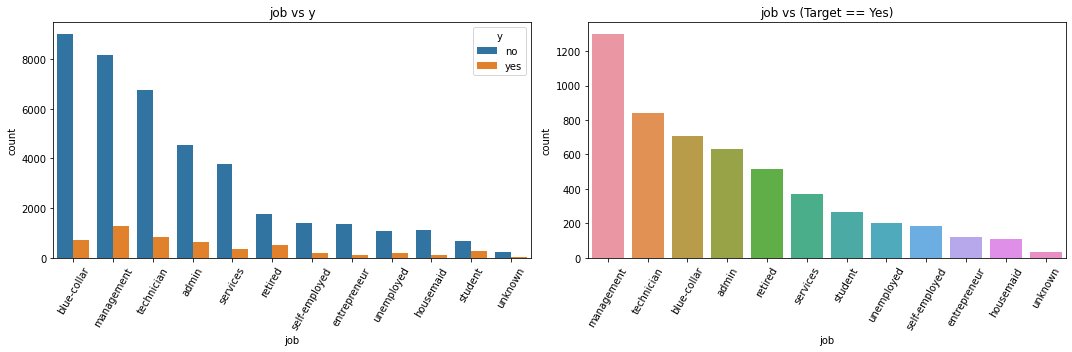

In [47]:
feature_vs_target(df, "job", "y")

In [ ]:

# df.job = df.job.map({'unknown': 1, 'housemaid': 2, 'entrepreneur': 3, 'self-employed': 4, 'unemployed': 5, 'student': 6, 'services': 7, 'retired': 8, 'admin': 9, 'blue-collar': 10, 'technician': 11, 'management': 12 })
# df["job"].unique()

The most targeted customers: Blue-collar job, but comparing with conversion rate, we end up in losing lot of money.(Better to avoid targetting Blue-collar customers a lot)
Convertion rate is maximum: Management.

Checking Relationship Between marital feature and y Target

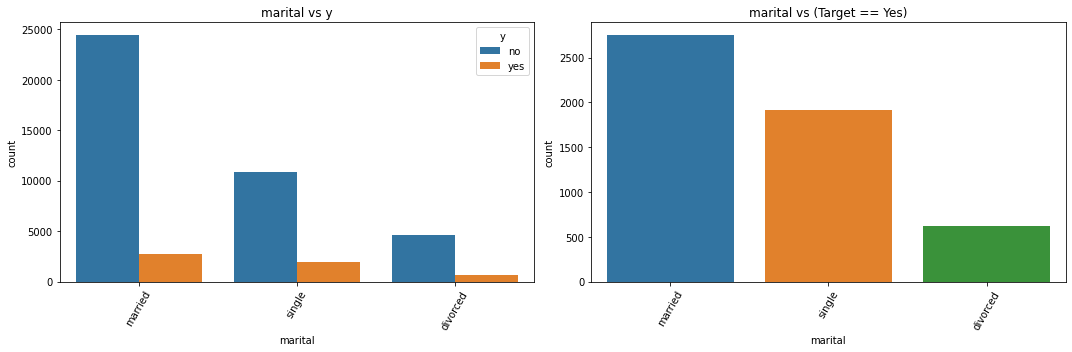

In [48]:

feature_vs_target(df, "marital", "y")

Married people are mostly opting for the insurance.
Divorced people don't care much on their health.

Checking Relationship in between Education_qual and y Target

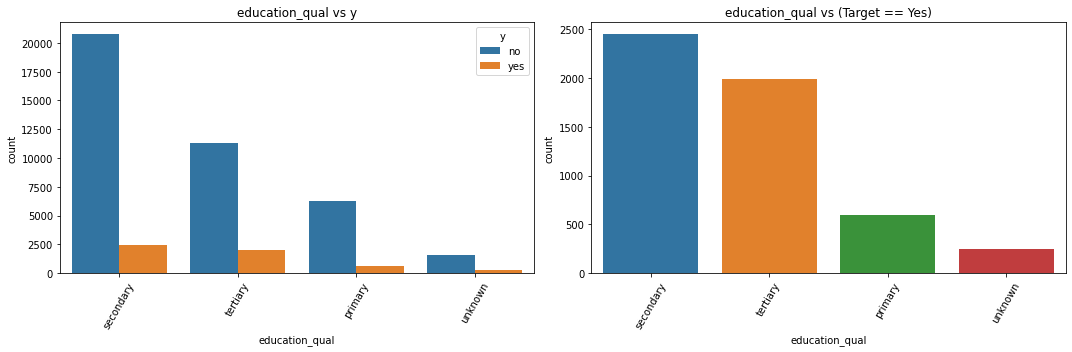

In [49]:
feature_vs_target(df, "education_qual", "y")

People with higher education(Secondary/Tertiary --> Collage/Masters) are option for insurance plans.
We need to concentrate on spreading awareness about health insurance to people with less education.

Checking Relationship in between the Call_type feature and y target

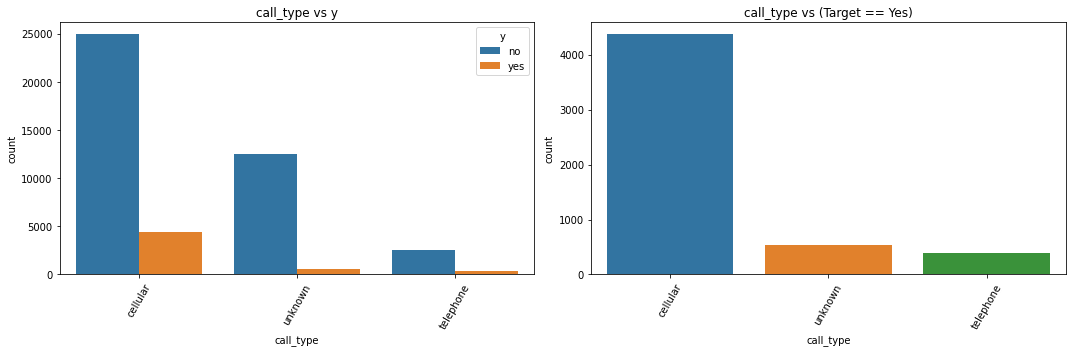

In [50]:

feature_vs_target(df, "call_type", "y")

cellular type conversation is contributing a lot towards customers opting for insurance plan.

Checking Relationship between the month feature and y target

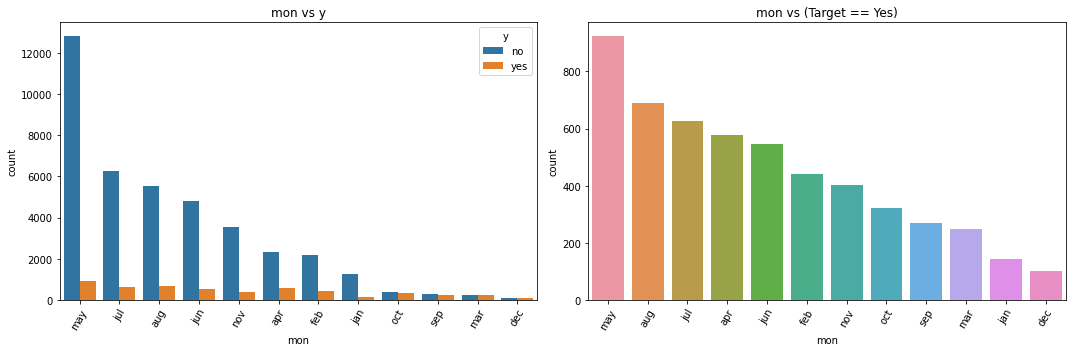

In [51]:

feature_vs_target(df, "mon", "y")

People opting for Insurance plans when targeted during start of new financial year/When they get their appraisal cycle result.

Checking the Relationship between prev_outcome feature and y target

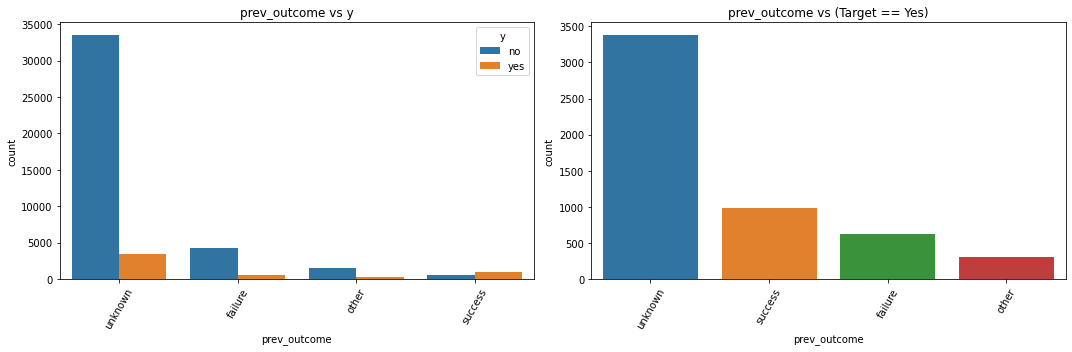

In [52]:
feature_vs_target(df, "prev_outcome", "y")

The relationship between prev_outcome and target is very less. Lets drop the feature.

*EDA For Numarical Columns*

In [53]:

def feature_vs_target_numeric(dataframe, feature, target):
  sns.set_theme(style="darkgrid",palette="bright")
  plt.figure(figsize=(20, 10))
  plt.subplot(211)
  sns.distplot(dataframe[feature])
  plt.title(feature + " vs " + target)
  plt.xticks(rotation=60)
  plt.subplot(212)
  sns.countplot(x=feature, hue=target, data=dataframe)
  plt.title(feature + " vs " + target)
  plt.tight_layout()
  plt.show()

Checking Relationship Between age feature and y target

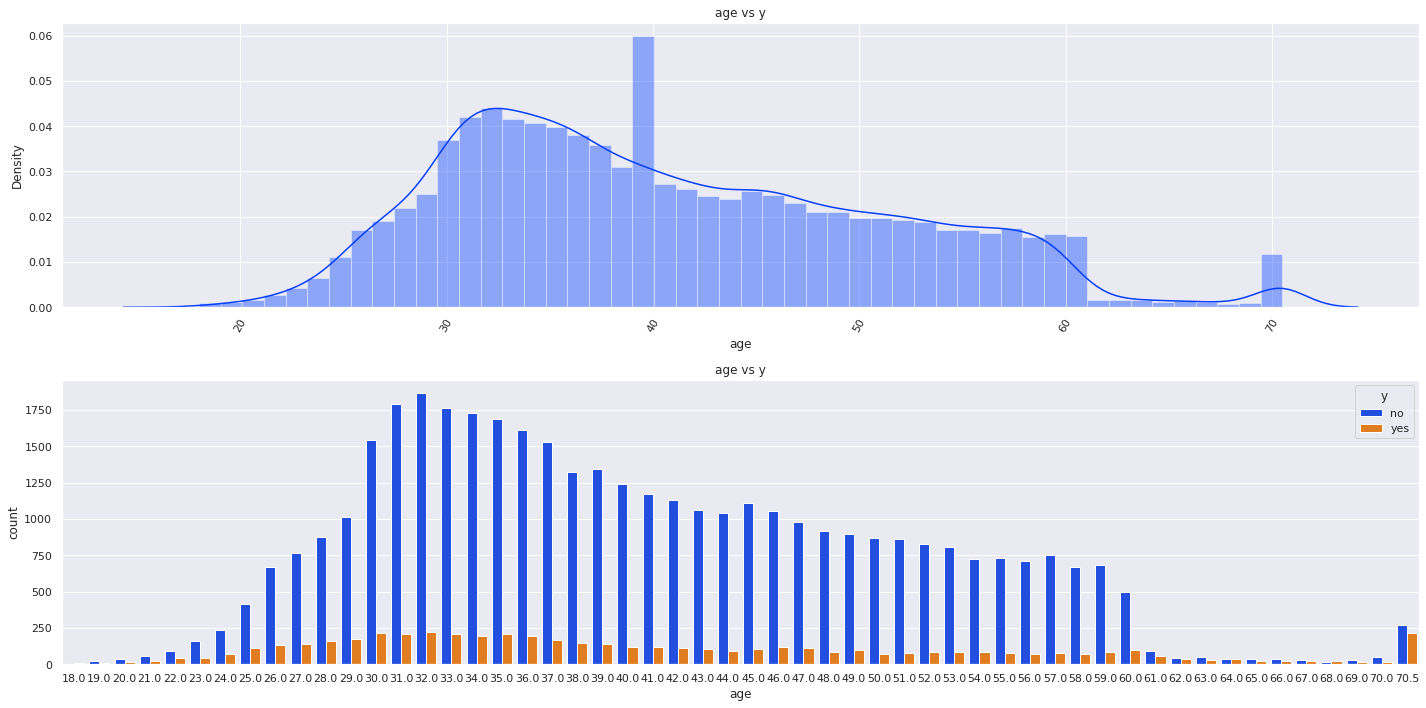

In [54]:

feature_vs_target_numeric(df, "age", "y")

People between 25 and 60 age are opting for insurance.
Senior citizens are not opting for insurance.
Also people below 18 years are not opting for insurance.

Checking Relationship in between day feature and y target

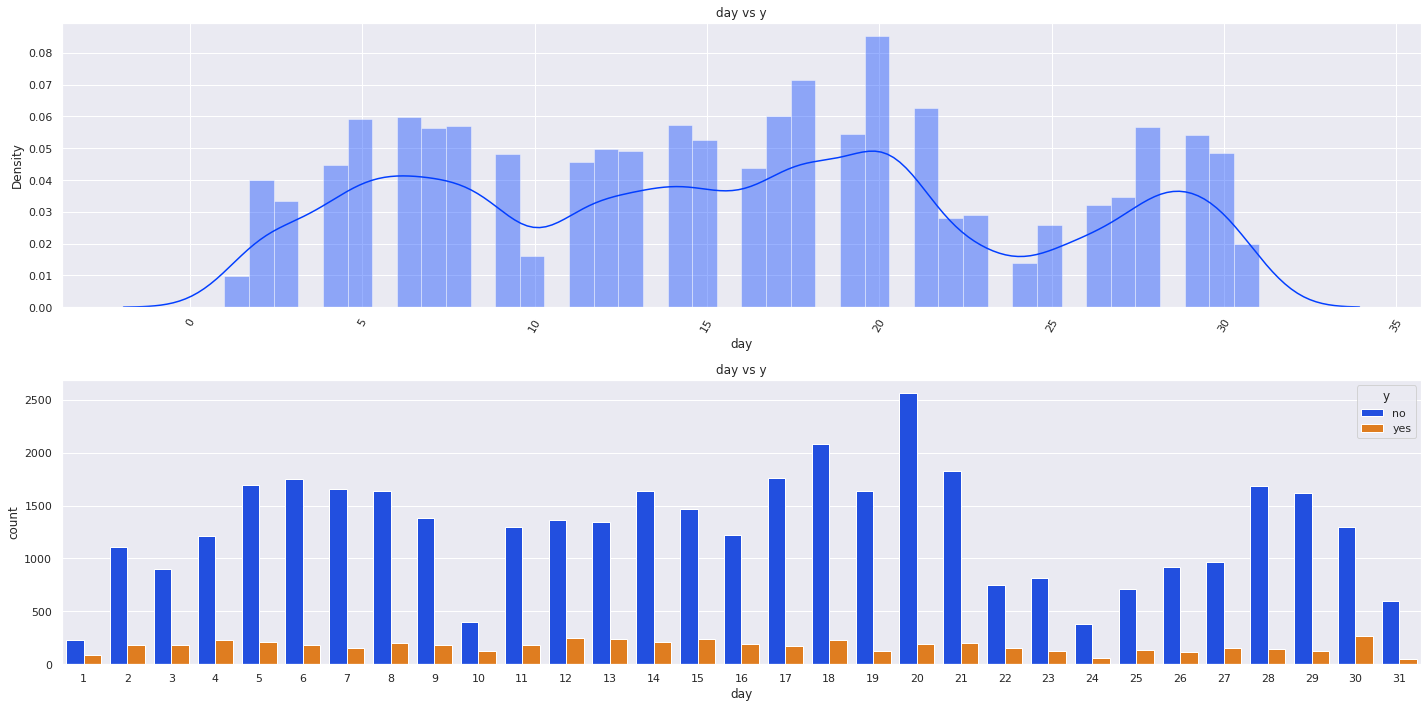

In [55]:

feature_vs_target_numeric(df, "day", "y")

Checking Relationship between Duration Feature and Y Target

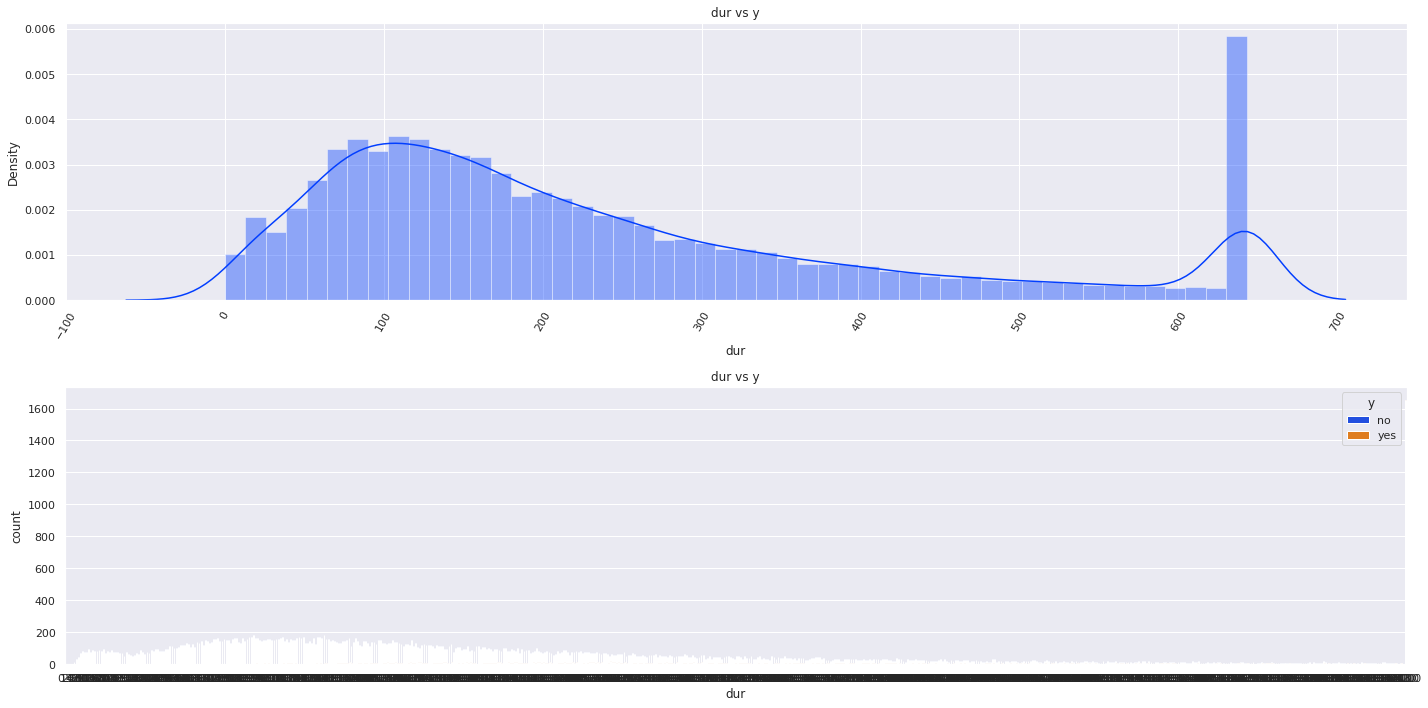

In [56]:

sns.set_theme(style="darkgrid",palette="tab10")
feature_vs_target_numeric(df, "dur", "y")

Checking Relationship in between num_calls feature and y target

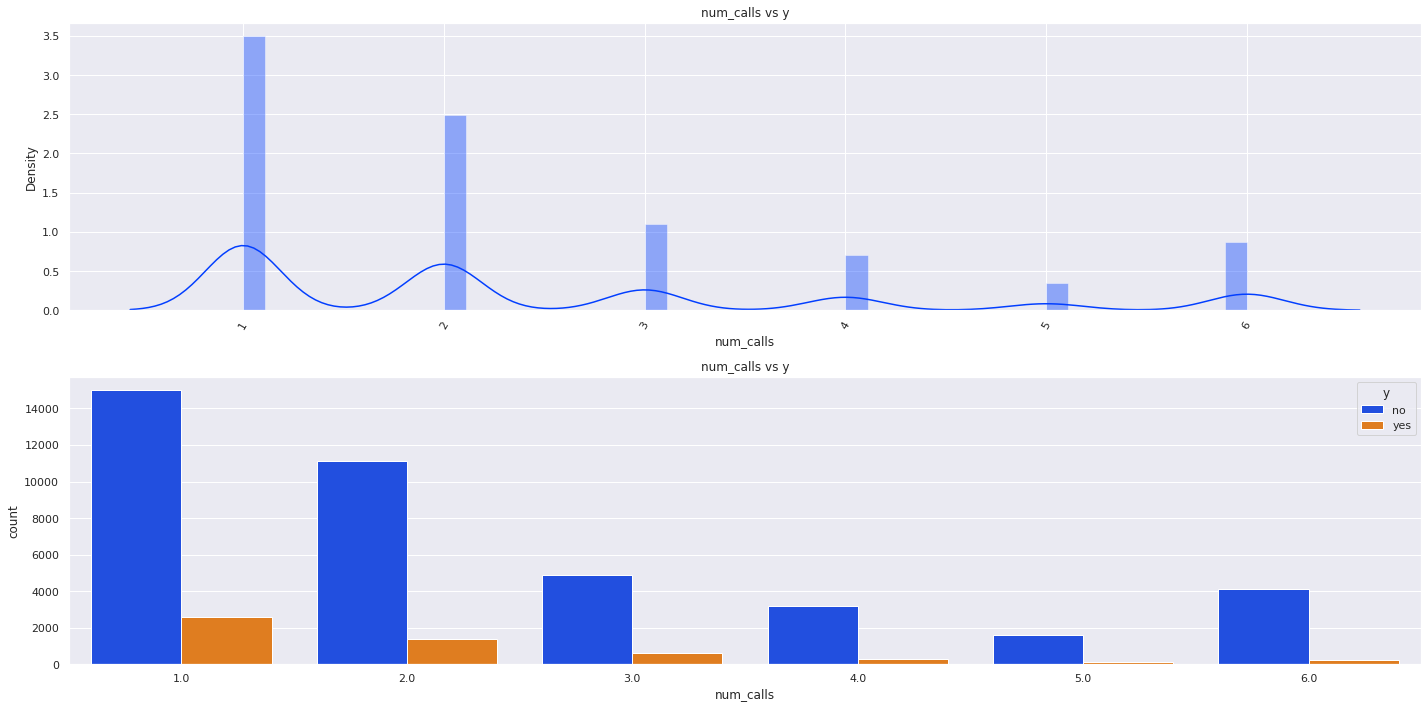

In [57]:

feature_vs_target_numeric(df, "num_calls", "y")

When contacted over phone, mostly customers opting for insurance in maximum 3 attempts.
As cost effective approach, avoid reaching customer over phone after 3 attempts.

Checking datatypes

In [58]:

df.dtypes

age               float64
job                object
marital            object
education_qual     object
call_type          object
day                 int64
mon                object
dur               float64
num_calls         float64
prev_outcome       object
y                  object
dtype: object

Change to proper datatype

In [59]:
df['age'] = df['age'].astype(int)
df['dur'] = df['dur'].astype(int)
df['num_calls'] = df['num_calls'].astype(int)

Label Encoding for Ordinal Categories

In [60]:
df.job = df.job.map({'unknown': 1, 'housemaid': 2, 'entrepreneur': 3, 'self-employed': 4, 'unemployed': 5, 'student': 6, 'services': 7, 'retired': 8, 'admin': 9, 'blue-collar': 10, 'technician': 11, 'management': 12 })
df.marital = df.marital.map({'divorced':1, 'single':2, 'married':3})
df.mon = df.mon.map({'dec': 1, 'jan': 2, 'mar' : 3, 'sep' : 4, 'oct' : 5, 'nov' : 6, 'feb' : 7, 'jun' : 8, 'apr' : 9, 'jul' : 10, 'aug' : 11, 'may' :12})
df.y = df.y.map({'yes':1, 'no':0})

# df.education_qual = df.education_qual.map({'unknown':1, 'primary':2, 'tertiary':3, 'secondary':4})
# df.call_type = df.call_type.map({'telephone':1, 'unknown':2, 'cellular':3})
# df.prev_outcome = df.prev_outcome.map({'unknown':1, 'failure':2, 'other':3, 'success':4})

One-Hot Encoding for Nominal Categories

In [61]:

df=pd.get_dummies(df,columns=["call_type", "education_qual","prev_outcome"])
df.head()

,age,job,marital,day,mon,dur,num_calls,y,call_type_cellular,call_type_telephone,call_type_unknown,education_qual_primary,education_qual_secondary,education_qual_tertiary,education_qual_unknown,prev_outcome_failure,prev_outcome_other,prev_outcome_success,prev_outcome_unknown
0,58,12,3,5,12,261,1,0,0,0,1,0,0,1,0,0,0,0,1
1,44,11,2,5,12,151,1,0,0,0,1,0,1,0,0,0,0,0,1
2,33,3,3,5,12,76,1,0,0,0,1,0,1,0,0,0,0,0,1
3,47,10,3,5,12,92,1,0,0,0,1,0,0,0,1,0,0,0,1
4,33,1,2,5,12,198,1,0,0,0,1,0,0,0,1,0,0,0,1


Final dataset after Encoding

In [62]:

df.head()

,age,job,marital,day,mon,dur,num_calls,y,call_type_cellular,call_type_telephone,call_type_unknown,education_qual_primary,education_qual_secondary,education_qual_tertiary,education_qual_unknown,prev_outcome_failure,prev_outcome_other,prev_outcome_success,prev_outcome_unknown
0,58,12,3,5,12,261,1,0,0,0,1,0,0,1,0,0,0,0,1
1,44,11,2,5,12,151,1,0,0,0,1,0,1,0,0,0,0,0,1
2,33,3,3,5,12,76,1,0,0,0,1,0,1,0,0,0,0,0,1
3,47,10,3,5,12,92,1,0,0,0,1,0,0,0,1,0,0,0,1
4,33,1,2,5,12,198,1,0,0,0,1,0,0,0,1,0,0,0,1


Checking Data is imbalanced or not

Class 0: 39916
Class 1: 5289
Proportion of class 0 is  88.3 %


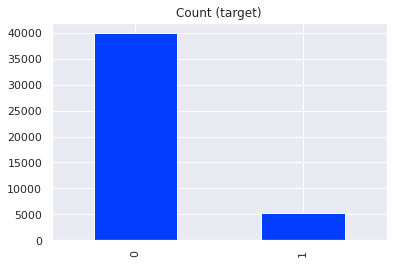

In [63]:

y_count = df.y.value_counts()
print('Class 0:', y_count[0])
print('Class 1:', y_count[1])
print('Proportion of class 0 is ', round(y_count[0] * 100 / (y_count[1] + y_count[0]), 2),'%')
y_count.plot(kind='bar', title='Count (target)');

More than 70 percent of the data belongs to one class.
The data is imbalanced.

Splitting the data

In [64]:
X = df.drop('y',axis=1).values
y = df['y'].values

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Feature Scaling

In [66]:
scaler = StandardScaler() 
scaler.fit(X_train,y_train) 
X_train_scaled = scaler.transform(X_train) 
X_test_scaled = scaler.transform(X_test)
     

Converting Imbalanced data to balanced data by using SMOTE and CLUSTER CENTROID SAMPLING (SMOTEENN)

In [67]:

smt = SMOTEENN(sampling_strategy='all')
X_smt, y_smt = smt.fit_resample(X_train_scaled, y_train)

In [68]:

Counter(y_smt)

Counter({0: 25721, 1: 30289})

Finally, The data is balanced.

Logistic Regression Model
Model Fitting

In [69]:

log_r = LogisticRegression()
log_r.fit(X_smt,y_smt)

LogisticRegression()

In [70]:
LogisticRegression()

LogisticRegression()

Evaluation Metrics for Classification Problem

Accuracy Of The Model

In [71]:

y_pred = log_r.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
     

Accuracy: 77.02%


AUROC Score Of The Model

In [74]:
#lr.score(X_test_scaled,y_test)
print( "AUROC on the sampled dataset : ",roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:, 1]))

NameError: ignored

KNearest Neighbours Model

In [75]:
knn_values=np.arange(10, 36)
cross_val_knn=[]
for k in knn_values:
  knn=KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_smt,y_smt)
  cross_val = cross_val_score(knn, X_test_scaled, y_test,cv = 15).mean()
  print("K value : ", k, "cross_val_score : ", cross_val)
  cross_val_knn.append(cross_val)
print("The best K-Value is {} and Cross_val_score is: {}".format(np.argmax(cross_val_knn) + 10, max(cross_val_knn)))

K value :  10 cross_val_score :  0.888949677599452
K value :  11 cross_val_score :  0.8881757693628572
K value :  12 cross_val_score :  0.8897239531394339
K value :  13 cross_val_score :  0.889613945775001
K value :  14 cross_val_score :  0.8901656354624073
K value :  15 cross_val_score :  0.8891711615418659
K value :  16 cross_val_score :  0.889834327807254
K value :  17 cross_val_score :  0.8901665537208749
K value :  18 cross_val_score :  0.8900545261878131
K value :  19 cross_val_score :  0.8896126602131461
K value :  20 cross_val_score :  0.8902763774336145
K value :  21 cross_val_score :  0.8904974940726416
K value :  22 cross_val_score :  0.8903867521014345
K value :  23 cross_val_score :  0.8908289853794886
K value :  24 cross_val_score :  0.8913821442804436
K value :  25 cross_val_score :  0.8918245612101912
K value :  26 cross_val_score :  0.8917132682839033
K value :  27 cross_val_score :  0.8918243775584976
K value :  28 cross_val_score :  0.8913815933253627
K value :  29 c

AUROC Score of the Model

In [76]:

knn = KNeighborsClassifier(31)
knn.fit(X_smt, y_smt)
knn.score(X_test_scaled,y_test)

0.7782324964052649

In [77]:

y_pred = knn.predict(X_test_scaled)
accuracy = roc_auc_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.42%


In [91]:

plot_roc_curve(knn, X_test_scaled, y_test)
plt.show()

NameError: ignored

Decision Tree Classifier Model

Model Fitting

In [79]:

dt = DecisionTreeClassifier()
dt.fit(X_smt, y_smt)

DecisionTreeClassifier()

Calculating Accuracy and AUROC Score of the Model

In [80]:
y_pred = dt.predict(X_test_scaled) 

# Compute test set accuracy
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(acc))
acc = roc_auc_score(y_test, y_pred)
print("Test set auc: {:.2f}".format(acc))
plot_roc_curve(dt, X_test_scaled, y_test)

Test set accuracy: 0.86
Test set auc: 0.82


NameError: ignored

In [81]:

acc = roc_auc_score(y_test, dt.predict(X_test_scaled))
print("Train set AUC : ", acc)

Train set AUC :  0.8167085695601657


Random Forest Classifier Model

Model Fitting

In [82]:

rf = RandomForestClassifier(n_estimators= 100, max_depth = 3, max_features='sqrt')

rf.fit(X_smt, y_smt)

RandomForestClassifier(max_depth=3)

Accuracy Of the Model

In [83]:
y_pred = rf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 71.94%


AUROC Score Of The Model

In [84]:

roc_auc_score(y_test, rf.predict_proba(X_test_scaled)[:, 1])

0.8757383998271724

XG-Boost Model

Model Fitting and Checking all Learning Rate Values

In [86]:
for lr in [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.2,0.5,0.7,1]:
  model = xgb.XGBClassifier(learning_rate = lr, n_estimators=100, verbosity = 0)
  model.fit(X_smt, y_smt)
  model.score(X_test_scaled, y_test) # scoring the model - r2 squared
  print("Learning rate : ", lr, " Train score : ", model.score(X_train_scaled, y_train), " Cross-Val score : ", np.mean(cross_val_score(model, X_train_scaled, y_train, cv=10)))
     

Learning rate :  0.01  Train score :  0.7807488109722376  Cross-Val score :  0.9007853309470274
Learning rate :  0.02  Train score :  0.8026213914390001  Cross-Val score :  0.902084872688215
Learning rate :  0.03  Train score :  0.8175257161818383  Cross-Val score :  0.9026379623875455
Learning rate :  0.04  Train score :  0.8315451830549718  Cross-Val score :  0.9026656172548021
Learning rate :  0.05  Train score :  0.8455093463112487  Cross-Val score :  0.9038823014354535
Learning rate :  0.06  Train score :  0.8543302731998673  Cross-Val score :  0.9046289216849634
Learning rate :  0.07  Train score :  0.8619898241344984  Cross-Val score :  0.9041863902882407
Learning rate :  0.08  Train score :  0.8655569074217454  Cross-Val score :  0.9042693625358129
Learning rate :  0.09  Train score :  0.8699535449618405  Cross-Val score :  0.9044906091196683
Learning rate :  0.1  Train score :  0.8747096560115032  Cross-Val score :  0.9046842467110817
Learning rate :  0.11  Train score :  0.87

AUROC Score Of The Model

In [87]:

model = xgb.XGBClassifier(learning_rate = 0.15, n_estimators=100)
model.fit(X_smt, y_smt)
model.score(X_test_scaled, y_test)

0.8737971463333702

In [88]:

roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

0.9258593207177015

In [89]:

for i in [log_r, knn, dt, rf, model]:
  auroc_score = roc_auc_score(y_test, i.predict_proba(X_test_scaled)[:, 1])*100
  print("AUROC Score of Model: {} is \033[1m{}%\033[0m".format(i, round(auroc_score,2)))

AUROC Score of Model: LogisticRegression() is 88.26%
AUROC Score of Model: KNeighborsClassifier(n_neighbors=31) is 87.74%
AUROC Score of Model: DecisionTreeClassifier() is 81.67%
AUROC Score of Model: RandomForestClassifier(max_depth=3) is 87.57%
AUROC Score of Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, ran

The AUROC Scores Of All MOdels are

AUROC Score of Model: LogisticRegression() is 88.27%
AUROC Score of Model: KNeighborsClassifier(n_neighbors=31) is 87.62%
AUROC Score of Model: DecisionTreeClassifier() is 79.81%
AUROC Score of Model: RandomForestClassifier(max_depth=3, max_features='sqrt') is 87.66%
AUROC Score of Model: XGBClassifier(learning_rate=0.15) is 91.78%

Conclusion: The Best Model For This Dataset Is XGBoost Classifier